# Analysis of Titanic dataset

### analysis out of seaborn and pandas plot

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.stats import gaussian_kde
import re

/tmp/ipykernel_182331/2247527196.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_df = pd.read_csv('data_titanic/train.csv')
test_df = pd.read_csv('data_titanic/test.csv')

In [ ]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

## helpers

In [3]:
def analysis_balance_labels(dataset):
    
    # preliminary analysis
    # general data analysis
    
    print(f'-----{analysis_balance_labels.__name__}:' )
    surv = dataset['Survived'].value_counts()
    print(f'Died: {surv[0]}')
    print(f'Survived: {surv[1]}')
    died_norm, surv_norm = dataset['Survived'].value_counts(normalize=True)
    print(f'Died normalizatad: {np.round(died_norm, 2)}')
    print(f'Survived normalizatad: {np.round(surv_norm, 2)}')
    proc_died = np.ceil(surv[0] / len(dataset) * 100)
    print(f'Died: {proc_died} %')
    print(f'Survived: {100-proc_died} %')

In [4]:
def bar_charts_survived_for_all(dataset, col, text):
    # only for train data (needs 'Survived' label)
    # chart how many groupdby column col
    # survived shows stacked bar plot

    temp = dataset.groupby([col], as_index=False).Survived.value_counts()
    bottom = np.zeros(len(temp.Survived.unique()))
    lab = None
    #print(temp.Survived.unique())

    fig, ax = plt.subplots()
    for i in (temp[col].unique()):
        p = ax.bar(temp.Survived.unique(),
                   temp[temp[col]==i].sort_values(by='Survived')['count'].to_numpy(),
                   0.8,
                   bottom=bottom,
                   label=i)
        bottom = bottom + temp[temp[col]==i].sort_values(by='Survived')['count'].to_numpy()
    #ax.set_xticklabels(temp.Survived.unique())
    #print(temp.Survived.unique())
    ax.set_xticks(np.sort(temp.Survived.unique()), temp.Survived.unique())
    ax.set_xlabel('Dead/Survived')
    ax.set_ylabel('Count')
    ax.grid()
    ax.legend()
    plt.title(text)
    plt.show()

In [5]:
def windowing_x_axes_of_hist(x:np.array):
    midle_of_bins = []
    for i in range(len(x)-1):
        midle_of_bins.append(np.round((x[i]+x[i+1])/2, 2))
    return midle_of_bins

In [6]:
## plot pdf of feature
def pdf_of_feature(df, col, xlabebl, nr_bins=20):  
    
    fig, ax = plt.subplots()
    x = ax.hist(col, nr_bins, density=True)
    new_x_axes = windowing_x_axes_of_hist(x[1])

    xy_spline = make_interp_spline(new_x_axes, x[0])
    xx = np.linspace(np.array(new_x_axes).min(), np.array(new_x_axes).max(), 500)
    yy = xy_spline(xx)
    ax.plot(xx, yy)
    ax.grid()
    ax.set_title('PDF of age of passangers')
    ax.set_xlabel(xlabebl)
    ax.set_ylabel('Normalized count')
    plt.show()

In [7]:
def plot_pdf_survived_or_not(df, column, alive, nr_of_bins, smooth, method='kde'):

    # estimate pdf of varibale and smooth using one of two methods

    x = column[~column.where(df.Survived == alive).isna()]

    hist, bins = np.histogram(x, bins=nr_of_bins, density=True)
    xaxes = windowing_x_axes_of_hist(bins)

    if smooth == False:
        return xaxes, hist
    else:
        if method == 'spline':
            xy_spline = make_interp_spline(xaxes, hist)
            xx = np.linspace(np.array(xaxes).min(), np.array(xaxes).max(), 500)
            yy = xy_spline(xx)
            return xx, yy

        if method == 'kde':
            xx = np.linspace(np.array(xaxes).min(), np.array(xaxes).max(), 500)
            kernel = gaussian_kde(x.T, bw_method=0.2)
            yy = kernel.pdf(xx)
            return xx, yy

## Exploratory Data Analysis

## number of survived in relation to gender

In [8]:
temp = train_df.groupby(['Sex'], as_index=False).Survived.count()
temp

,Sex,Survived
0,female,314
1,male,577


In [ ]:
print(train_df.head(10))
print("="*80)
print(train_df.info())

In [ ]:
test_df.info()

In [9]:
analysis_balance_labels(train_df)

-----analysis_balance_labels:
Died: 549
Survived: 342
Died normalizatad: 0.62
Survived normalizatad: 0.38
Died: 62.0 %
Survived: 38.0 %


***
- some of columns contain missing data (Age, Cabin, Embarked)
- more passangers died - 62%, survived - 38%
***

# Is there dependency Sex <--> Survived?

In [ ]:
bar_charts_survived_for_all(train_df, 'Sex', 'count dead/survive in each Sex')
print('='*80)
print('1 - survived, 0 - dead')

***
- men was majority on board
- the majority of survivors was women
***

***
# Is there dependency Pclass <--> Survived?

In [ ]:
bar_charts_survived_for_all(train_df, 'Pclass', 'count dead/survive in each Pclass')
print('='*80)
print('1 - survived, 0 - dead')

In [ ]:
pivot_tab =  pd.pivot_table(train_df,
                   index='Survived',
                   columns='Pclass',
                   values='Ticket',
                   aggfunc="count")
print("="*80)
print('Sum dead and survived in each class:')
print(pivot_tab)

print("="*80)
print('Sum all pearsons in each class:')
print(pivot_tab.sum())

print("="*80)
print('Survived factor in each class:')
train_df.groupby('Pclass').Survived.mean()

***
- the most passengers come from 3rd class although only 23% passengers survived
- 63% from class 1 survived
- 47% from class 1 survived
***

## Realtion Pclass <--> Sex, influance of gender on survival on each class

In [ ]:
width = 0.25
multiplier = 0
color = ('r', 'b')

fig, ax = plt.subplots()
for i in train_df.Pclass.unique():
    for c, j in zip(color, train_df.Sex.unique()):
        offset = width * multiplier
        y = train_df.loc[(train_df.Pclass == i) & (train_df.Sex == j)].Pclass.loc[train_df.Survived == 1].value_counts().values
        ax.bar(i+offset, y, width=width, label=j, color=c)
        multiplier += 1
    multiplier = 0

ax.set_xticks(train_df.Pclass.unique(), train_df.Pclass.unique())
ax.grid()
ax.legend(loc='best', bbox_to_anchor=(1, 1, 0., 0.))
ax.set_xlabel('Pclass')
ax.set_ylabel('Survived')
plt.title('Count survived in each Pclass taking Sex')
plt.show()

In [13]:
train_df.groupby(['Pclass', 'Sex']).Survived.mean().to_frame()

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

***
- the major impact on survival in class 1 and 2 had gender
***

## Analysis of relation age <--> survived

In [ ]:
pdf_of_feature(train_df, train_df.Age, xlabebl='Age', nr_bins=20)

In [ ]:
x_survived_age, y_survived_age = plot_pdf_survived_or_not(train_df,
                                                          train_df.Age,
                                                          alive=1,
                                                          nr_of_bins=30,
                                                          smooth=True,
                                                          method='kde')

x_died_age, y_died_age = plot_pdf_survived_or_not(train_df,
                                                  train_df.Age,
                                                  alive=0,
                                                  nr_of_bins=30,
                                                  smooth=True,
                                                  method='kde')

fig, ax = plt.subplots()
ax.plot(x_survived_age, y_survived_age, label='survived')
ax.plot(x_died_age, y_died_age, label='dead')
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Normalized count')
ax.set_title("Survived or not PDF according to Age")
ax.grid()
plt.show()

***
- pdfs of age separate in grouped of dead and survived shows that age is not important factor
- exception is the age in range ~(0 years old, 8 yearsold)
***

## Relation fare (price) <--> survived

In [ ]:
pdf_of_feature(train_df, train_df.Fare, xlabebl='Fare', nr_bins=40)

In [ ]:
# Huge disparcy of Fare values - needs to make binning
# Let's introducy 4 categories: cheap, normal, expansive, premium and analysis in this groups probability of survive
# so let's make binning of 4 groups

train_df.head(10)

In [ ]:
# qcut - quantile-based discretization function (groups of 25%)
fare_labels = ['cheap', 'normal', 'expansive', 'premium']
train_df['Fare_labels'] = pd.qcut(train_df.Fare, len(fare_labels), labels=fare_labels)

In [ ]:
bar_charts_survived_for_all(train_df, 'Fare_labels', 'count dead/survive according to grouped Fare')
print('='*80)
print('1 - survived, 0 - dead')

In [ ]:
fare_labels = ['cheap', 'normal', 'expansive', 'premium']
train_df['Fare_labels'] = pd.qcut(train_df.Fare, len(fare_labels), labels=fare_labels)

xx = train_df.groupby('Fare_labels').Survived.count()

fig, ax = plt.subplots()
x = [i[0] for i in train_df[train_df['Survived']==1].groupby('Fare_labels')['Survived'].value_counts().index.values]
y = train_df[train_df['Survived']==1].groupby('Fare_labels')['Survived'].value_counts().values/xx.values
ax.bar(x, y, label = x)
ax.set_xlabel('Fare class')
ax.set_ylabel('Count of survived')
ax.grid()
plt.legend()
plt.show()

***
- in cheap group survival rate equals ~20%
- in normalgroup survival rate equals ~30%
- in expansive survival rate equals ~45%
- in premium survival rate equals ~58%
***

## Explanation of relation embarked <--> survived

In [ ]:
bar_charts_survived_for_all(train_df, 'Embarked', 'count dead/survive according to Embarked')
print('='*80)
print('1 - survived, 0 - dead')

In [ ]:
x =[i[0] for i in train_df[train_df['Survived']==1].groupby('Embarked').Survived.value_counts().index.values]
y = train_df[train_df['Survived']==1].groupby('Embarked').Survived.value_counts().values

yy = train_df.groupby('Embarked').Survived.count()

fig, ax = plt.subplots(1, 2)
#fig.tight_layout(pad=0.04)

ax[0].bar(x, y/yy.values, label=x)
ax[0].set_title("Counts survived vs place of embarked")
ax[0].set_ylabel('Survival rate')
ax[0].set_xlabel('label of Embarked place')
ax[0].set_ylim([0, 1])
#ax[0].margins(2, 2)
ax[0].grid()

x =[i[0] for i in train_df[train_df['Survived']==0].groupby('Embarked').Survived.value_counts().index.values]
y = train_df[train_df['Survived']==0].groupby('Embarked').Survived.value_counts().values

#fig, ax = plt.subplots()
ax[1].bar(x, y/yy.values, label=x)
ax[1].set_title("Counts dead vs place of embarked")
ax[1].set_title("Counts dead vs place of embarked")
ax[1].set_ylabel('Dead rate')
ax[1].set_xlabel('label of Embarked place')
ax[1].set_ylim([0, 1])
ax[1].grid()

plt.subplots_adjust(left=.01, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

***
- the majority passagners was embarked in S although only 30% of them survived
- the highest rate of survived was embarked in C 58%
***

## Is there relation place of embarked <--> pclass

In [ ]:

width = 0.25
multiplier = np.zeros(3)
ii = np.arange(len(train_df.Pclass.unique()))

fig, ax = plt.subplots()
for i in train_df.Pclass.unique():
    offset = width * multiplier
    x = train_df[train_df['Pclass']==i].groupby('Embarked').Pclass.count()
    ax.bar(ii + offset, x.values, width, label=i)    
    ax.set_title("Counts embarked place in each class")
    ax.set_ylabel('Count embarked')
    #ax.set_xlabel('label of Pclass place')
    multiplier += 1
    #ax.set_ylim([0, 500])    

# be carefull and verify the order of xticks label we have to sort the values 
ax.set_xticks(ii + width, np.sort(train_df.Embarked[~train_df.Embarked.isna()].unique()))
ax.legend()
ax.grid()
plt.show()


***
- the majority of embarked at C were 1. class persons
- the majority of embarked at S were 3. class persons
***

## Gender distribution responsible for dead rate in various embarked place

In [ ]:
width = 0.25
multiplier = np.zeros(len(train_df.Embarked.unique())-1)
ii = np.arange(len(train_df.Embarked.unique())-1)

fig, ax = plt.subplots()
for i in train_df.Sex.unique():
    offset = width * multiplier
    x = train_df[train_df['Sex']==i].groupby('Embarked').Sex.count()    
    ax.bar(ii + offset, x.values, width, label=i)    
    #ax.set_title("Counts embarked place in each class")
    #ax.set_ylabel('Count embarked')
    multiplier += 1
  

# be carefull and verify the order of xticks label we have to sort the values 
ax.set_xticks(ii + width, np.sort(train_df.Embarked[~train_df.Embarked.isna()].unique()))
ax.legend()
ax.grid()
plt.show()

***
- the majority embarked in S was man
- it confirms gender impact
***

## Influance the number of sibilings or children/parents for survive 

In [ ]:
width = 0.25
multiplier = 0
marg = np.arange(len(train_df['Survived'].unique()))

yy = train_df.groupby('Parch').Survived.count()

fig, ax = plt.subplots(1, 2)
for i in train_df.Survived.unique():
    offset = width * multiplier
    x = train_df[train_df['Survived']==i].groupby('Parch').count().Sex.index.values
    y = train_df[train_df['Survived']==i].groupby('Parch').count().Sex
    ax[0].bar(x + offset, y, width=width, label=i)
    multiplier += 1

ax[0].set_title('Count of survived/dead in relation\nto number of Parch')
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel('Parch')
ax[0].set_ylabel('Count of survived/dead')  

offset = width * multiplier
x = train_df[train_df['Survived']==0].groupby('Parch').count().Sex.index.values
y = train_df[train_df['Survived']==0].groupby('Parch').count().Sex/yy.values
ax[1].bar(x + offset, y, width=width, label=0)
multiplier += 1

ax[1].set_title('Rate of survived/dead in relation\nto number of Parch')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Parch')
ax[1].set_ylabel('Rate of survived/dead')  

plt.subplots_adjust(left=.01, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

print('='*80)
print('1 - survived, 0 - dead')

In [ ]:
width = 0.25
multiplier = 0
marg = np.arange(len(train_df['Survived'].unique()))

yy = train_df.groupby('SibSp').Survived.count()

fig, ax = plt.subplots(1, 2)
for i in train_df.Survived.unique():
    offset = width * multiplier
    x = train_df[train_df['Survived']==i].groupby('SibSp').count().Sex.index.values
    y = train_df[train_df['Survived']==i].groupby('SibSp').count().Sex
    ax[0].bar(x + offset, y, width=width, label=i)
    multiplier += 1


ax[0].set_title('Count of survived/dead in relation\nto number of SibSp')
ax[0].legend()
ax[0].grid()
ax[0].set_xlabel('SibSp')
ax[0].set_ylabel('Count of survived/dead')


offset = width * multiplier
x = train_df[train_df['Survived']==0].groupby('SibSp').count().Sex.index.values
y = train_df[train_df['Survived']==0].groupby('SibSp').count().Sex/yy.values

ax[1].bar(x + offset, y, width=width, label=0)
multiplier += 1

ax[1].set_title('Rate of survived/dead in relation\nto number of SibSp')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('SibSp')
ax[1].set_ylabel('Rate of dead')

plt.subplots_adjust(left=.01, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()


print('='*80)
print('1 - survived, 0 - dead')

***
- the realation Parch and SibSp to surival rate is similar 
- people with small number of relatives have more chance to survived
***

# Feature engineering 

## problem of names and conveyd there titles

In [14]:
pattern = re.compile(r'[A-Z]{1}[a-z]+[.]{1}')
train_df['Title'] = train_df['Name'].apply(lambda x: re.findall(pattern, x)[0])

In [11]:
pd.set_option('display.max_rows', train_df.shape[0]+1)
#train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,NaN,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,NaN,S,Mr.
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr.
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S,Mr.
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S,Master.
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S,Mrs.
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C,Mrs.


## Check new feature 'title' impact on survival rate

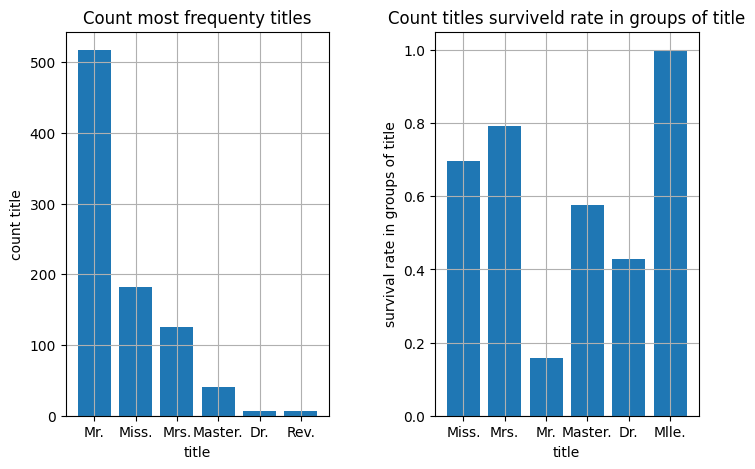

In [15]:
x = train_df.groupby('Title').Survived.count().sort_values(ascending=False)[:6]
#print(x)
xx = train_df[train_df['Survived']==1].groupby('Title').Survived.count().sort_values(ascending=False)
count_all_titles = [train_df[train_df.Title == i].Survived.count() for i in xx.index]
n_important_title = 6


fig, ax = plt.subplots(1, 2)
ax[0].bar(x.index, x.values)
ax[0].grid()
ax[0].set_title('Count most frequenty titles')
ax[0].set_xlabel('title')
ax[0].set_ylabel('count title')

ax[1].bar(xx.index[:n_important_title], xx.values[:n_important_title]/count_all_titles[:n_important_title])
ax[1].grid()
ax[1].set_title('Count titles surviveld rate in groups of title')
ax[1].set_xlabel('title')
ax[1].set_ylabel('survival rate in groups of title')
plt.subplots_adjust(left=.01, bottom=0.1, right=0.999, top=0.9, wspace=0.4, hspace=0.4)

***
- female titles result in a highest survival rate
***

In [16]:
pattern = re.compile(r'[A-Z]{1}[a-z]+[.]{1}')
test_df['Title'] = test_df['Name'].apply(lambda x: re.findall(pattern, x)[0])
test_df.Title.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Ms.', 'Col.', 'Rev.', 'Dr.',
       'Dona.'], dtype=object)

## problem of Cabin and Ticket

In [ ]:
train_df

In [ ]:
test_df

In [17]:
train_df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [ ]:
train_df

In [18]:
test_df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [ ]:
test_df

## Problem of feature family size (SibSp, Parch)

In [19]:
train_df['Fam_size'] = train_df['SibSp'] + train_df['Parch']
test_df['Fam_size'] = test_df['SibSp'] + test_df['Parch']

train_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [ ]:
train_df

In [ ]:
test_df

In [ ]:
train_df.Fam_size.unique()

In [ ]:
train_df.Fam_size.unique()

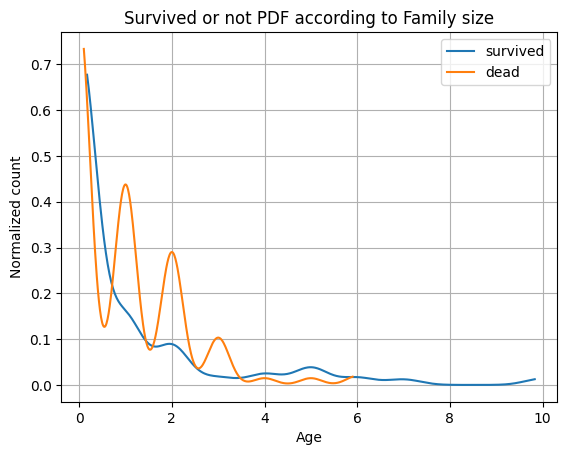

In [20]:
x_died_fam_size, y_died_fam_size = plot_pdf_survived_or_not(train_df,
                                                  train_df.Fam_size,
                                                  alive=0,
                                                  nr_of_bins=30,
                                                  smooth=True,
                                                  method='kde')

x_surv_fam_size, y_surv_fam_size = plot_pdf_survived_or_not(train_df,
                                                  train_df.Fam_size,
                                                  alive=1,
                                                  nr_of_bins=30,
                                                  smooth=True,
                                                  method='kde')

fig, ax = plt.subplots()
ax.plot(x_died_fam_size, y_died_fam_size, label='survived')
ax.plot(x_surv_fam_size, y_surv_fam_size, label='dead')
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Normalized count')
ax.set_title("Survived or not PDF according to Family size")
ax.grid()
plt.show()

In [21]:
map_family_size = {0: 'solo',
                   1: 'small',
                   2: 'small',
                   3: 'small',
                   4: 'big',
                   5: 'big',
                   6: 'very big',
                   7: 'very big',
                   8: 'very big',
                   9: 'very big',
                   10: 'very big'    
}

train_df['Fam_type'] = train_df.Fam_size.map(map_family_size)

In [ ]:
train_df

In [22]:
test_df['Fam_type'] = test_df.Fam_size.map(map_family_size)

In [ ]:
test_df

# Train classifier

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [24]:
y = train_df['Survived']
features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Fam_type', 'Age', 'Sex']
X = train_df[features]

X.head()

,Pclass,Fare,Title,Embarked,Fam_type,Age,Sex
0,3,7.2500,Mr.,S,small,22.0,male
1,1,71.2833,Mrs.,C,small,38.0,female
2,3,7.9250,Miss.,S,solo,26.0,female
3,1,53.1000,Mrs.,S,small,35.0,female
4,3,8.0500,Mr.,S,solo,35.0,male


In [ ]:
train_df.info()

In [ ]:
X_test = test_df[features]
X_test.head()

## Use RandomForestClassifier

In [25]:
numerical = ['Fare', 'Age']
categorical = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Sex']

numerical_transform = SimpleImputer(strategy='median')

categorical_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transform, numerical),
    ('cat', categorical_transform, categorical)
])

titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=6))
])

titanic_pipeline.fit(X, y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.833


## Use RandomForestClassifier and Standard Scaler

In [26]:
numerical = ['Fare', 'Age']
categorical = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Sex']

numerical_transform = Pipeline(steps=[
    ('si', SimpleImputer(strategy='median')),
    ('sts', StandardScaler())
])

categorical_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transform, numerical),
    ('cat', categorical_transform, categorical)
])

titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=6))
])

titanic_pipeline.fit(X, y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.834


In [27]:
def interpret_pred(y_pred):
    res = []
    if y_pred < 0.5:
        res.append(0)
    else:
        res.append(1)
    return res  

In [ ]:
data_test2 = pd.read_csv('data_titanic/test.csv', sep=',')
data_test = data_test2.copy()

#print(data_test.head())
#print("="*40)
data_test['Fam_size'] = data_test['SibSp'] + data_test['Parch']
#print(data_test.head())
#print("="*40)
data_test['Fam_type'] = data_test.Fam_size.map(map_family_size)
#print(data_test.head())
#print("="*40)
pattern = re.compile(r'[A-Z]{1}[a-z]+[.]{1}')
data_test['Title'] = data_test['Name'].apply(lambda x: re.findall(pattern, x)[0])
#print(data_test.head())
#print("="*40)
data_test.drop(['Name', 'PassengerId', 'Cabin', 'Ticket', 'Fam_size', 'SibSp', 'Parch'], axis=1, inplace=True)
data_test.head()

y_test_predicted = titanic_pipeline.predict(data_test)
y_test_predicted
with open("titanic_main10_sub_RandomForestClassifier.csv", "a") as f:
     f.write("PassengerId,Survived\n")
     for i in zip(data_test2.PassengerId, y_test_predicted):
         #print(i[0], i[1])
         res = str(f"{i[0]},{interpret_pred(i[1])[0]}\n")
         f.write(res)

In [ ]:
X.head()

## BaggingClassifier

In [ ]:
numerical = ['Fare', 'Age']
categorical = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Sex']

numerical_transform = Pipeline(steps=[
    ('si', SimpleImputer(strategy='median')),
    ('sts', StandardScaler())
])

categorical_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transform, numerical),
    ('cat', categorical_transform, categorical)
])

titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BaggingClassifier(KNeighborsClassifier(), max_samples=0.9, max_features=0.9))
])

titanic_pipeline.fit(X, y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

numerical = ['Fare', 'Age']
categorical = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Sex']

estimators = [('ridge', RidgeCV()), 
              ('lasso', LassoCV(random_state=42)), 
              ('knr', KNeighborsRegressor(n_neighbors=5, metric='euclidean'))]

final_estimator = GradientBoostingRegressor(n_estimators=25, subsample=0.5, min_samples_leaf=25, max_features=1, random_state=42)
reg = StackingRegressor(estimators=estimators, final_estimator=final_estimator)

numerical_transform = Pipeline(steps=[
    ('si', SimpleImputer(strategy='median')),
    ('sts', StandardScaler())
])

categorical_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transform, numerical),
    ('cat', categorical_transform, categorical)
])

titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', reg)
])

titanic_pipeline.fit(X, y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

## AdaBoost

In [28]:
from sklearn.ensemble import AdaBoostClassifier

numerical = ['Fare', 'Age']
categorical = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Sex']

numerical_transform = Pipeline(steps=[
    ('si', SimpleImputer(strategy='median')),
    ('sts', StandardScaler())
])

categorical_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transform, numerical),
    ('cat', categorical_transform, categorical)
])

titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', AdaBoostClassifier(n_estimators=1000, algorithm="SAMME", learning_rate=0.2))
])

titanic_pipeline.fit(X, y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

data_test2 = pd.read_csv('data_titanic/test.csv', sep=',')
data_test = data_test2.copy()

#print(data_test.head())
#print("="*40)
data_test['Fam_size'] = data_test['SibSp'] + data_test['Parch']
#print(data_test.head())
#print("="*40)
data_test['Fam_type'] = data_test.Fam_size.map(map_family_size)
#print(data_test.head())
#print("="*40)
pattern = re.compile(r'[A-Z]{1}[a-z]+[.]{1}')
data_test['Title'] = data_test['Name'].apply(lambda x: re.findall(pattern, x)[0])
#print(data_test.head())
#print("="*40)
data_test.drop(['Name', 'PassengerId', 'Cabin', 'Ticket', 'Fam_size', 'SibSp', 'Parch'], axis=1, inplace=True)
data_test.head()

y_test_predicted = titanic_pipeline.predict(data_test)
y_test_predicted
with open("titanic_main12_sub_AdaBoostClassifier_2.csv", "a") as f:
     f.write("PassengerId,Survived\n")
     for i in zip(data_test2.PassengerId, y_test_predicted):
         #print(i[0], i[1])
         res = str(f"{i[0]},{interpret_pred(i[1])[0]}\n")
         f.write(res)

Cross validation score: 0.827
